## Video classification with a 3D convolutional neural network

In [1]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report,classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

/Users/sijiehuang/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Load Data and Data Preprocessing

In [2]:
#@title

def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped. 

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class. 

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.
    
    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test. 

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename
  
  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class
    
  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [3]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL, 
                        num_classes = 10, 
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir = download_dir)

train :


100%|██████████| 300/300 [01:47<00:00,  2.78it/s]


val :


100%|██████████| 100/100 [00:37<00:00,  2.67it/s]


test :


100%|██████████| 100/100 [00:36<00:00,  2.75it/s]


In [4]:
import os
def remove_ds_store(path):
    for root, dirs, files in os.walk(path):
        for file in files:
            if file == '.DS_Store':
                os.remove(os.path.join(root, file))

remove_ds_store('UCF101_subset/train')
remove_ds_store('UCF101_subset/val')
remove_ds_store('UCF101_subset/test')

### EDA

In [5]:
import os
from collections import defaultdict

def count_videos_per_class(base_dir):
    class_counts = defaultdict(int)
    for cls in os.listdir(base_dir):
        cls_dir = os.path.join(base_dir, cls)
        if os.path.isdir(cls_dir):
            class_counts[cls] = len(os.listdir(cls_dir))
    return class_counts

splits = ['train', 'val', 'test']
root = 'UCF101_subset'
counts = {split: count_videos_per_class(os.path.join(root, split)) for split in splits}

# Total stats
for split in splits:
    print(f"{split}: {sum(counts[split].values())} videos in {len(counts[split])} classes")

train: 310 videos in 10 classes
val: 110 videos in 10 classes
test: 110 videos in 10 classes


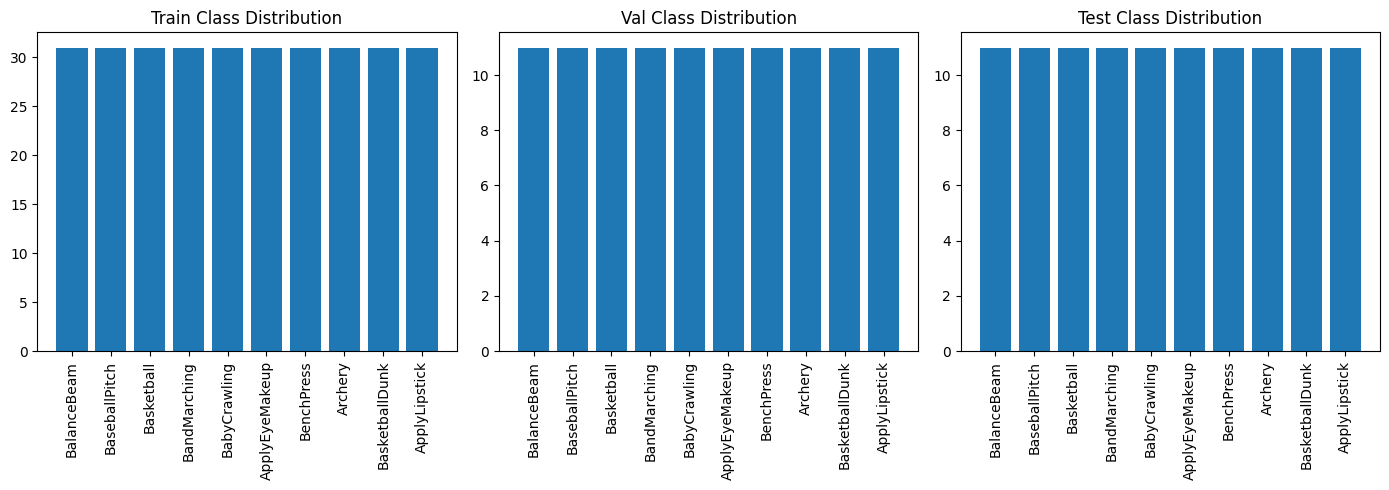

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
for i, split in enumerate(splits):
    plt.subplot(1, 3, i + 1)
    plt.bar(counts[split].keys(), counts[split].values())
    plt.xticks(rotation=90)
    plt.title(f"{split.capitalize()} Class Distribution")
    plt.tight_layout()

plt.show()

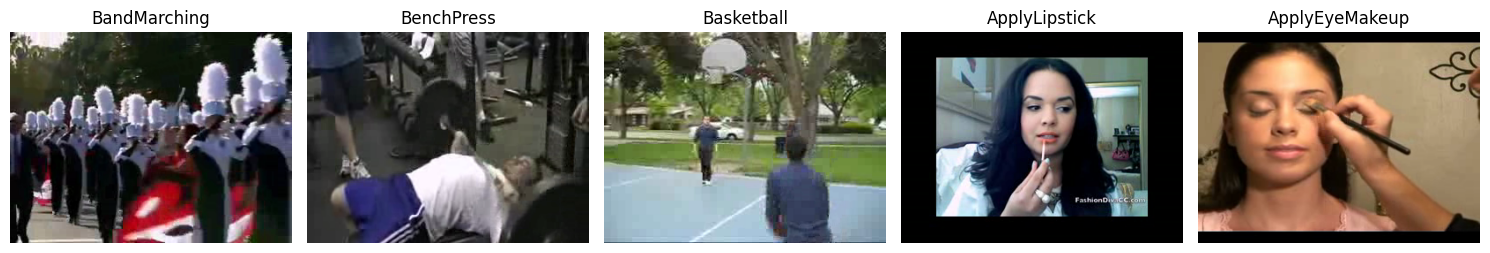

In [7]:
# sample a few frames from the dataset
def sample_frame(video_path, frame_no=10):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
    ret, frame = cap.read()
    cap.release()
    return frame if ret else None

sample_classes = random.sample(list(counts['train'].keys()), 5)
plt.figure(figsize=(15, 6))

for i, cls in enumerate(sample_classes):
    video_list = os.listdir(os.path.join(root, 'train', cls))
    sample_vid = os.path.join(root, 'train', cls, random.choice(video_list))
    frame = sample_frame(sample_vid)
    if frame is not None:
        plt.subplot(1, 5, i+1)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(cls)
        plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Turn the dataset into frames
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)


val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

2025-05-07 12:00:15.366282: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-05-07 12:00:15.366305: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-07 12:00:15.366323: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1746637215.366805 17633381 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1746637215.367281 17633381 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


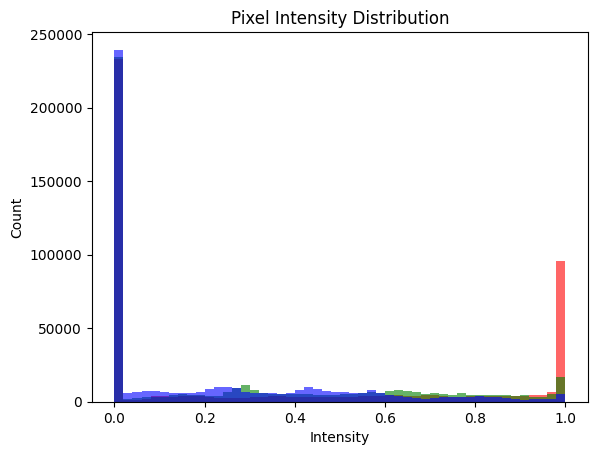

2025-05-07 12:00:26.313026: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# Pixel Intensity Histogram (Across All Frames in a Video)
def show_pixel_distribution(ds, sample_idx=0):
    for i, (video, label) in enumerate(ds.take(sample_idx + 1)):
        if i == sample_idx:
            video = video.numpy()
            # Combine all frames into one array
            pixels = video.reshape(-1, 3)  # (total_pixels, 3)
            colors = ('r', 'g', 'b')
            for j, col in enumerate(colors):
                plt.hist(pixels[:, j], bins=50, color=col, alpha=0.6)
            plt.title("Pixel Intensity Distribution")
            plt.xlabel("Intensity")
            plt.ylabel("Count")
            plt.show()

show_pixel_distribution(train_ds, sample_idx=1)

In [ ]:
# Mean / Std of frames across dataset
def get_mean_std(ds, num_batches=100):
    means = []
    stds = []
    for i, (video, _) in enumerate(ds.take(num_batches)):
        vid_np = video.numpy()
        means.append(np.mean(vid_np))
        stds.append(np.std(vid_np))
    print(f"Mean pixel intensity: {np.mean(means):.4f}")
    print(f"Std pixel intensity: {np.mean(stds):.4f}")

get_mean_std(train_ds)

Mean pixel intensity: 0.2102
Std pixel intensity: 0.2496


2025-05-07 12:01:24.026707: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


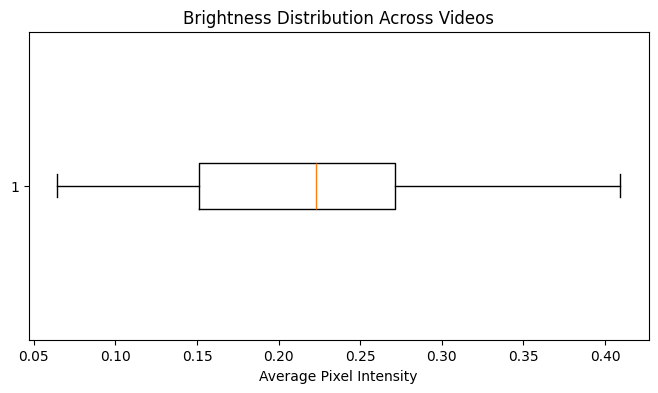

In [ ]:
# frame brightness
def plot_brightness_outliers(ds, num_videos=100):
    brightness = []
    for video, _ in ds.take(num_videos):
        avg_brightness = tf.reduce_mean(video).numpy()
        brightness.append(avg_brightness)

    plt.figure(figsize=(8, 4))
    plt.boxplot(brightness, vert=False)
    plt.title("Brightness Distribution Across Videos")
    plt.xlabel("Average Pixel Intensity")
    plt.show()

plot_brightness_outliers(train_ds)

In [12]:
# Batch the data
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

### Modeling

In [36]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications

# Configuration
NUM_FRAMES = 10          
HEIGHT, WIDTH = 224, 224  
CHANNELS = 3
NUM_CLASSES = 10        

inputs = tf.keras.Input(shape=(NUM_FRAMES, HEIGHT, WIDTH, CHANNELS))


base_model = applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    pooling='avg',       
    input_shape=(HEIGHT, WIDTH, CHANNELS)
)
base_model.trainable = False 


x = layers.TimeDistributed(base_model)(inputs) 


x = layers.GlobalAveragePooling1D()(x)


x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)


model = models.Model(inputs, outputs)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 10, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 2048)       │    23,564,800 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,091,914 (91.90 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [37]:
frames, label = next(iter(train_ds))
model.build(frames)

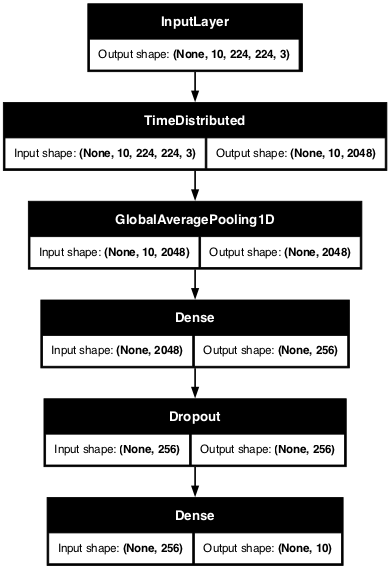

In [38]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [39]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [40]:
history = model.fit(x = train_ds,
                    epochs = 10, 
                    validation_data = val_ds)

Epoch 1/10


/Users/sijiehuang/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


     38/Unknown 54s 1s/step - accuracy: 0.1374 - loss: 3.2267

2025-05-07 15:35:05.550374: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14496669188310813988
2025-05-07 15:35:05.551028: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7346242154231791925
2025-05-07 15:35:05.551036: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4189318754836416113
2025-05-07 15:35:05.551040: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5211027515563599607
2025-05-07 15:35:05.551043: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11020810822394713667
2025-05-07 15:35:05.551046: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13433561199144176599
2025-05-07 15:35:05.551049: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv 

38/38 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.1388 - loss: 3.2152 - val_accuracy: 0.5200 - val_loss: 1.4865
Epoch 2/10


2025-05-07 15:35:24.188361: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-07 15:35:24.188381: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16200101412595333528
2025-05-07 15:35:24.188389: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11015506704703829146
2025-05-07 15:35:24.188393: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6729744351533277567
2025-05-07 15:35:24.188404: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7383396141082232378


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3690 - loss: 1.8283

2025-05-07 15:36:12.977259: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14496669188310813988
2025-05-07 15:36:12.977273: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5211027515563599607
2025-05-07 15:36:12.977279: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7346242154231791925
2025-05-07 15:36:12.977284: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13433561199144176599
2025-05-07 15:36:12.977286: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13949780853062222670
2025-05-07 15:36:12.977289: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3853285215716760549
2025-05-07 15:36:12.977291: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv 

38/38 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.3709 - loss: 1.8240 - val_accuracy: 0.7800 - val_loss: 0.9632
Epoch 3/10


2025-05-07 15:36:29.236657: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16200101412595333528
2025-05-07 15:36:29.236681: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6729744351533277567
2025-05-07 15:36:29.236703: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11015506704703829146
2025-05-07 15:36:29.236710: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7383396141082232378


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5971 - loss: 1.2018

2025-05-07 15:37:17.843330: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14496669188310813988
2025-05-07 15:37:17.843348: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13949780853062222670
2025-05-07 15:37:17.843354: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17591489723159958680
2025-05-07 15:37:17.843357: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13941492560051583460
2025-05-07 15:37:17.843360: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5947218230569568708
2025-05-07 15:37:17.843362: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4972934517454401000
2025-05-07 15:37:17.843365: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

38/38 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.5985 - loss: 1.1992 - val_accuracy: 0.9100 - val_loss: 0.6679
Epoch 4/10


2025-05-07 15:37:33.600888: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-07 15:37:33.600911: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16200101412595333528
2025-05-07 15:37:33.600930: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11015506704703829146
2025-05-07 15:37:33.600935: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6729744351533277567
2025-05-07 15:37:33.600944: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7383396141082232378


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6649 - loss: 1.0209

2025-05-07 15:38:21.849753: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14496669188310813988
2025-05-07 15:38:21.849768: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13949780853062222670
2025-05-07 15:38:21.849772: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17591489723159958680
2025-05-07 15:38:21.849774: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7346242154231791925
2025-05-07 15:38:21.849781: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10973180958299841809
2025-05-07 15:38:21.849785: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5947218230569568708
2025-05-07 15:38:21.849789: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

38/38 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.6663 - loss: 1.0177 - val_accuracy: 0.8800 - val_loss: 0.5266
Epoch 5/10


2025-05-07 15:38:37.539083: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16200101412595333528
2025-05-07 15:38:37.539097: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11015506704703829146
2025-05-07 15:38:37.539102: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6729744351533277567
2025-05-07 15:38:37.539111: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7383396141082232378


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8059 - loss: 0.6640

2025-05-07 15:39:24.619631: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14496669188310813988
2025-05-07 15:39:24.619648: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13949780853062222670
2025-05-07 15:39:24.619652: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 121053878356586147
2025-05-07 15:39:24.619659: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7346242154231791925
2025-05-07 15:39:24.619664: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3853285215716760549
2025-05-07 15:39:24.619668: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13433561199144176599
2025-05-07 15:39:24.619672: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

38/38 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.8055 - loss: 0.6631 - val_accuracy: 0.9100 - val_loss: 0.4320
Epoch 6/10


2025-05-07 15:39:40.382620: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16200101412595333528
2025-05-07 15:39:40.382634: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11015506704703829146
2025-05-07 15:39:40.382641: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7383396141082232378
2025-05-07 15:39:40.382645: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6729744351533277567


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8109 - loss: 0.5974

2025-05-07 15:40:27.910452: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14496669188310813988
2025-05-07 15:40:27.910468: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13949780853062222670
2025-05-07 15:40:27.910472: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17591489723159958680
2025-05-07 15:40:27.910475: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4189318754836416113
2025-05-07 15:40:27.910484: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5947218230569568708
2025-05-07 15:40:27.910488: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7346242154231791925
2025-05-07 15:40:27.910490: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv 

38/38 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.8116 - loss: 0.5960 - val_accuracy: 0.9400 - val_loss: 0.3529
Epoch 7/10


2025-05-07 15:40:43.990653: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16200101412595333528
2025-05-07 15:40:43.990670: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11015506704703829146
2025-05-07 15:40:43.990674: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7383396141082232378
2025-05-07 15:40:43.990679: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6729744351533277567


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8696 - loss: 0.3859

2025-05-07 15:41:31.955331: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14496669188310813988
2025-05-07 15:41:31.955349: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13949780853062222670
2025-05-07 15:41:31.955351: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 121053878356586147
2025-05-07 15:41:31.955359: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17591489723159958680
2025-05-07 15:41:31.955363: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7346242154231791925
2025-05-07 15:41:31.955368: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5947218230569568708
2025-05-07 15:41:31.955370: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

38/38 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.8700 - loss: 0.3864 - val_accuracy: 0.9400 - val_loss: 0.3104
Epoch 8/10


2025-05-07 15:41:47.975617: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-07 15:41:47.975634: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6729744351533277567
2025-05-07 15:41:47.975638: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16200101412595333528
2025-05-07 15:41:47.975646: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11015506704703829146
2025-05-07 15:41:47.975652: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7383396141082232378


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8860 - loss: 0.4182

2025-05-07 15:42:35.219438: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14496669188310813988
2025-05-07 15:42:35.219451: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13949780853062222670
2025-05-07 15:42:35.219454: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17591489723159958680
2025-05-07 15:42:35.219458: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5947218230569568708
2025-05-07 15:42:35.219462: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13941492560051583460
2025-05-07 15:42:35.219466: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5610569411114696044
2025-05-07 15:42:35.219468: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

38/38 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.8860 - loss: 0.4174 - val_accuracy: 0.9500 - val_loss: 0.2739
Epoch 9/10


2025-05-07 15:42:51.504136: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16200101412595333528
2025-05-07 15:42:51.504152: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6729744351533277567
2025-05-07 15:42:51.504177: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11015506704703829146
2025-05-07 15:42:51.504184: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7383396141082232378


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9232 - loss: 0.2852

2025-05-07 15:43:41.575185: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10973180958299841809
2025-05-07 15:43:41.575377: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3587600813310317845
2025-05-07 15:43:41.575381: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11020810822394713667
2025-05-07 15:43:41.575387: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15430442032615897091
2025-05-07 15:43:41.575442: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7589413883779238387
2025-05-07 15:43:41.575479: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7258849541130021577
2025-05-07 15:43:41.575593: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv 

38/38 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.9231 - loss: 0.2852 - val_accuracy: 0.9400 - val_loss: 0.2608
Epoch 10/10


2025-05-07 15:43:58.631120: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16200101412595333528
2025-05-07 15:43:58.631134: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11015506704703829146
2025-05-07 15:43:58.631147: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6729744351533277567
2025-05-07 15:43:58.631153: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7383396141082232378


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8946 - loss: 0.2999

2025-05-07 15:44:46.138737: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14496669188310813988
2025-05-07 15:44:46.138753: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13949780853062222670
2025-05-07 15:44:46.138758: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17591489723159958680
2025-05-07 15:44:46.138795: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 121053878356586147
2025-05-07 15:44:46.138803: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5947218230569568708
2025-05-07 15:44:46.138809: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7346242154231791925
2025-05-07 15:44:46.138815: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

38/38 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.8951 - loss: 0.2994 - val_accuracy: 0.9600 - val_loss: 0.2279


2025-05-07 15:45:01.794669: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16200101412595333528
2025-05-07 15:45:01.794699: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11015506704703829146
2025-05-07 15:45:01.794704: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6729744351533277567
2025-05-07 15:45:01.794712: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7383396141082232378


### Show the results

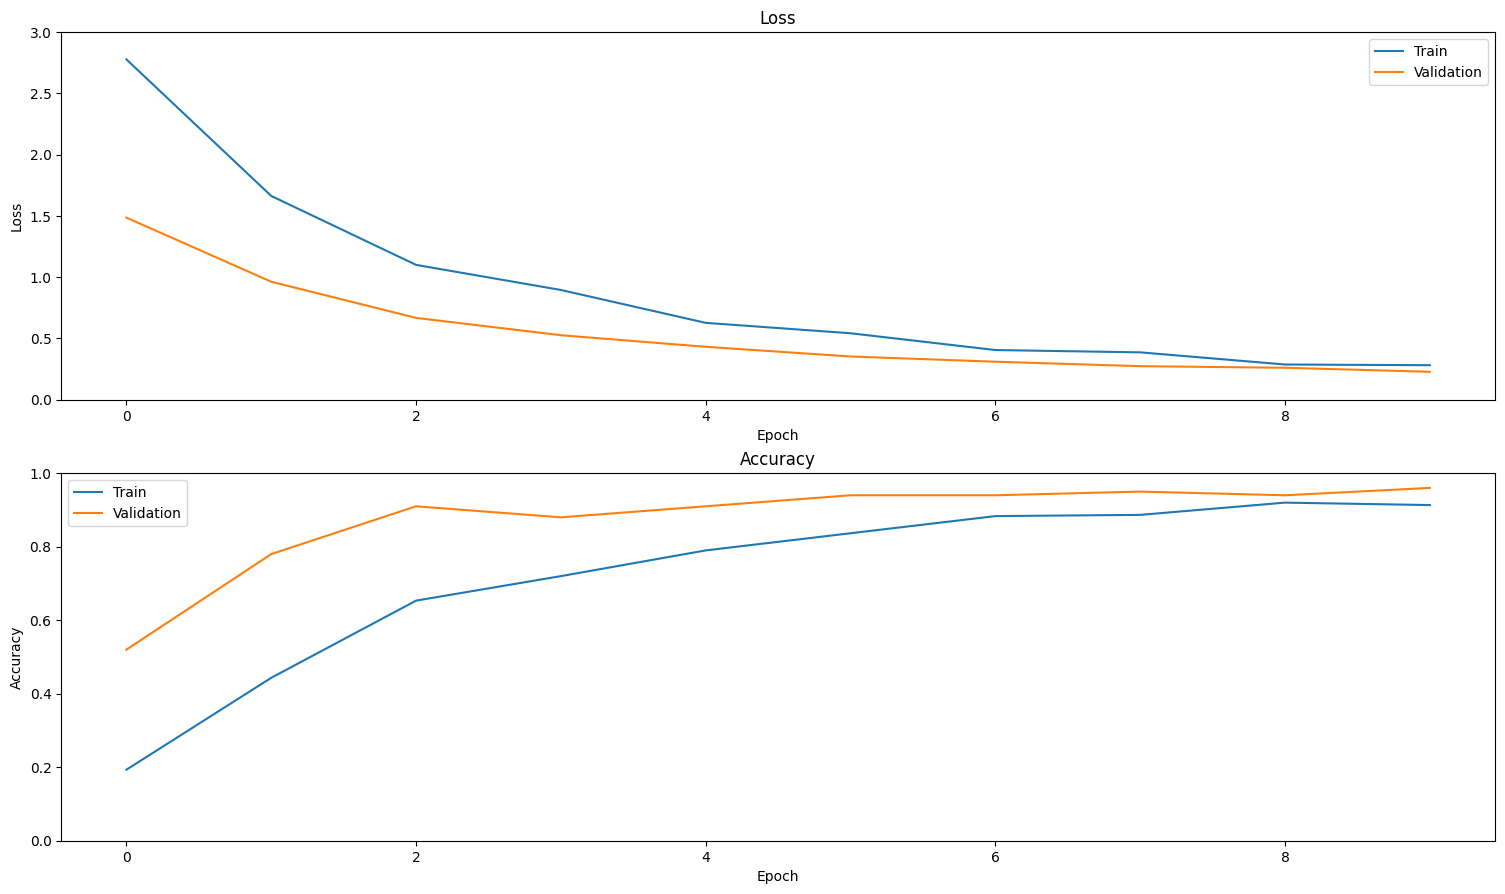

In [41]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')
  
  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

In [42]:
model.evaluate(test_ds, return_dict=True)

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9476 - loss: 0.2282


2025-05-07 15:47:01.776492: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16200101412595333528
2025-05-07 15:47:01.776511: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11015506704703829146
2025-05-07 15:47:01.776516: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7383396141082232378
2025-05-07 15:47:01.776520: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6729744351533277567


{'accuracy': 0.9599999785423279, 'loss': 0.20126314461231232}

In [43]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [44]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [45]:
fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

38/38 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step


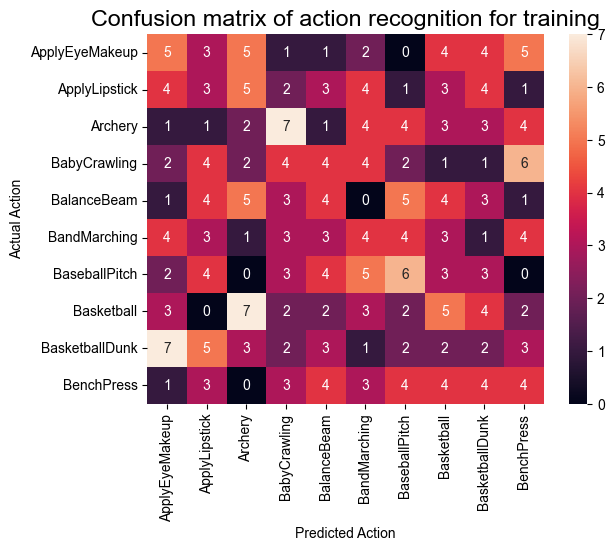

In [46]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step


/Users/sijiehuang/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


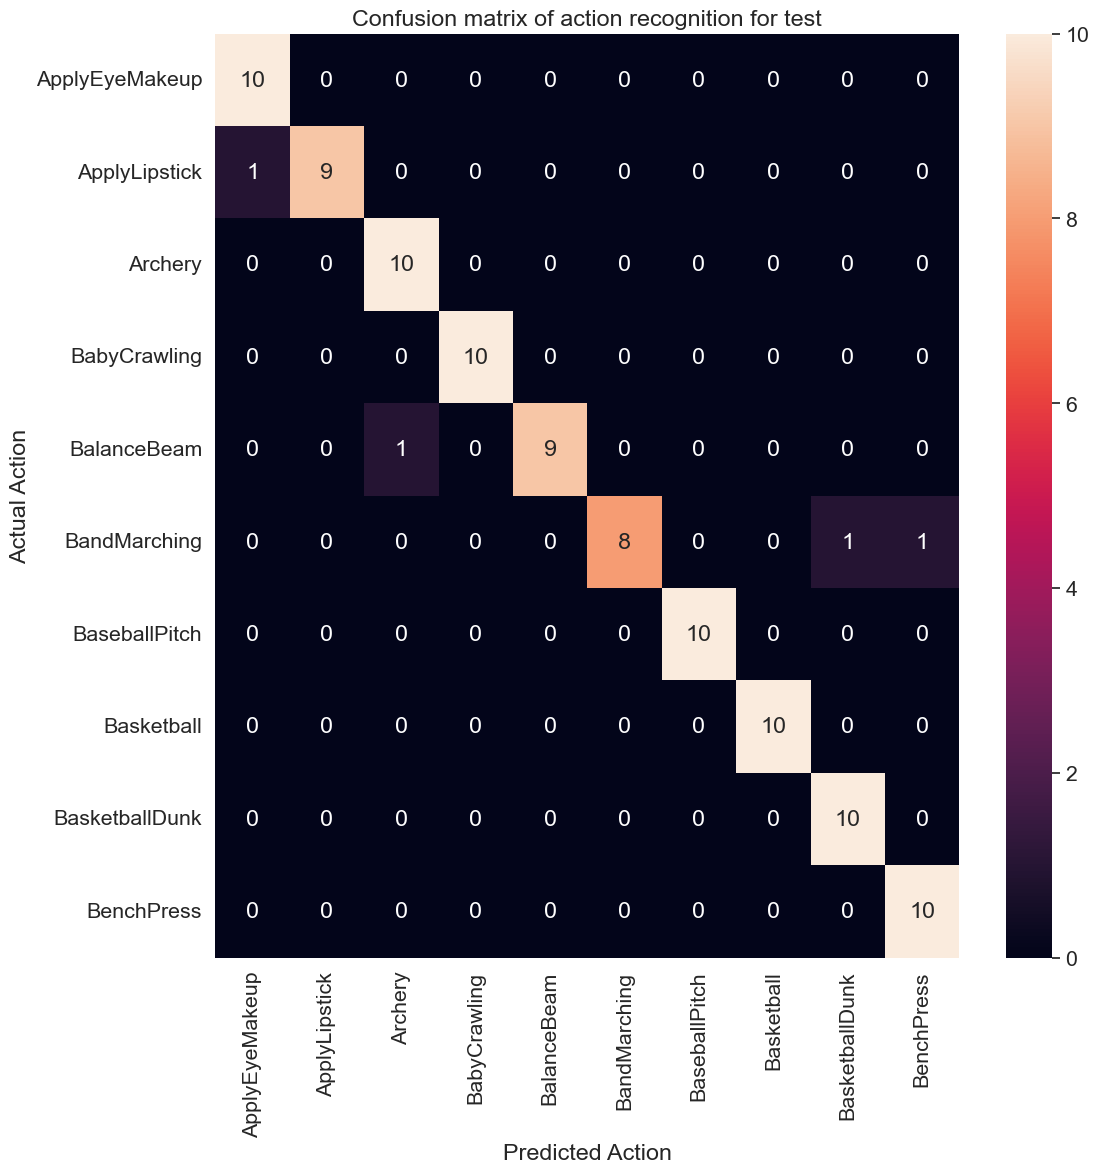

In [47]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

In [48]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    
    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 
    
    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
  
  return precision, recall

In [49]:
precision, recall = calculate_classification_metrics(actual, predicted, labels)

In [50]:
print(precision)

{'ApplyEyeMakeup': 0.9090909090909091, 'ApplyLipstick': 1.0, 'Archery': 0.9090909090909091, 'BabyCrawling': 1.0, 'BalanceBeam': 1.0, 'BandMarching': 1.0, 'BaseballPitch': 1.0, 'Basketball': 1.0, 'BasketballDunk': 0.9090909090909091, 'BenchPress': 0.9090909090909091}


In [51]:
print(recall)

{'ApplyEyeMakeup': 1.0, 'ApplyLipstick': 0.9, 'Archery': 1.0, 'BabyCrawling': 1.0, 'BalanceBeam': 0.9, 'BandMarching': 0.8, 'BaseballPitch': 1.0, 'Basketball': 1.0, 'BasketballDunk': 1.0, 'BenchPress': 1.0}
